# Visual evaluation of top FFT matches based on similarity on clean data

In [1]:
import numpy as np
import sys
import csv
import scipy.io as sio
from scipy.fftpack import fft, ifft
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
import operator
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

In [2]:
%matplotlib inline

In [3]:
#base_dir = '/home/ibanez/data/amnh/darwin_notes/'
base_dir = '/data/amnh/darwin/'
curves_fft_dir = base_dir + 'image_csvs_fft/'
fft_similarity_dir = base_dir + 'fft_similarity_clean/'
base_image_dir = base_dir + 'images/'
base_fft_dir = base_dir + 'image_csvs_fft/'
base_csv_dir = base_dir + 'image_csvs/'

In [4]:
top_matches = pd.read_csv(base_dir + 'top_items_sorted.txt', index_col=False, header=None, sep=' ');
top_matches.columns = ["image1","image2","fft_score"]
top_matches.head()

,image1,image2,fft_score
0,MS-DAR-00048-000-00189_south,MS-DAR-00048-000-00189_north_fft.mat,0.999921
1,MS-DAR-00089-000-00017_north,MS-DAR-00205-00002-000-00431_north_fft.mat,0.999893
2,MS-DAR-00087-000-00010_south,MS-DAR-00087-000-00008_north_fft.mat,0.999853
3,MS-DAR-00085-000-00150_south,MS-DAR-00084-00002-000-00307_north_fft.mat,0.999843
4,MS-DAR-00209-00009-000-00088_south,MS-DAR-00209-00009-000-00168_north_fft.mat,0.999837


In [5]:
def save_match(row_index):
    with open("/data/amnh/darwin/confirmed_matches.csv", "a+") as f:        
        image1_basename = top_matches["image1"][row_index]
        image2_basename = top_matches["image2"][row_index]
        fft_score = top_matches["fft_score"][row_index]
        print(image1_basename, image2_basename, fft_score)
        image1_filename = image1_basename[:-6] + '.jpg'
        image2_filename = image2_basename[:-14] + '.jpg'
        print(image1_filename)
        print(image2_filename)
        
        if 'south' in image1_basename:
            f.write("{},{},{}\n".format(image2_filename, image1_filename, fft_score))
        else:
            f.write("{},{},{}\n".format(image1_filename, image2_filename, fft_score))

In [6]:
def check_match_curves(row_index):
    image1_basename = top_matches["image1"][row_index]
    image2_basename = top_matches["image2"][row_index]
    fft_score = top_matches["fft_score"][row_index]
    print(image1_basename, image2_basename, fft_score)
    fft1_filename = base_fft_dir + image1_basename + '_fft.mat'
    fft2_filename = base_fft_dir + image2_basename
    print(fft1_filename)
    print(fft2_filename)
    curve1_filename = base_csv_dir + image1_basename + '.csv'
    curve2_filename = base_csv_dir + image2_basename[:-8] + '.csv'
    print(curve1_filename)
    print(curve2_filename)
    if 'south' in image1_basename and 'south' in image2_basename:
        print('CONFLICTING BORDERS!')
        return
    if 'north' in image1_basename and 'north' in image2_basename:
        print('CONFLICTING BORDERS!')
        return
    fft1 = sio.loadmat(fft1_filename)['fft']
    fft2 = sio.loadmat(fft2_filename)['fft']
    curve1restored = np.real(ifft(fft1))
    curve2restored = np.real(ifft(fft2))
    curve1xy = pd.read_csv(curve1_filename)
    curve2xy = pd.read_csv(curve2_filename)
    curve1xyn = curve1xy - curve1xy.mean()
    curve2xyn = curve2xy - curve2xy.mean()
    curve1y = curve1xyn.ix[:,1] 
    curve2y = curve2xyn.ix[:,1]
    print(curve1y.size)
    print(curve2y.size)
    commonsize = min(curve1y.size, curve2y.size)
    rms = sqrt(mean_squared_error(curve1y[:commonsize],curve2y[:commonsize]))
    print(rms)
    plt.figure()
    plt.plot(curve1y)
    plt.plot(curve2y)

In [7]:
def compute_match_curves(row_index):
    image1_basename = top_matches["image1"][row_index]
    image2_basename = top_matches["image2"][row_index]
    fft_score = top_matches["fft_score"][row_index]
    image1_filename = image1_basename[:-6] + '.jpg'
    image2_filename = image2_basename[:-14] + '.jpg'
    fft1_filename = base_fft_dir + image1_basename + '_fft.mat'
    fft2_filename = base_fft_dir + image2_basename
    curve1_filename = base_csv_dir + image1_basename + '.csv'
    curve2_filename = base_csv_dir + image2_basename[:-8] + '.csv'
    if 'south' in image1_basename and 'south' in image2_basename:
        return 10000, row_index, image1_filename, image2_filename
    if 'north' in image1_basename and 'north' in image2_basename:
        return 10000, row_index, image1_filename, image2_filename
    curve1xy = pd.read_csv(curve1_filename)
    curve2xy = pd.read_csv(curve2_filename)
    curve1xyn = curve1xy - curve1xy.mean()
    curve2xyn = curve2xy - curve2xy.mean()
    curve1y = curve1xyn.ix[:,1] 
    curve2y = curve2xyn.ix[:,1]
    commonsize = min(curve1y.size, curve2y.size)
    rms = sqrt(mean_squared_error(curve1y[:commonsize],curve2y[:commonsize]))
    return rms, row_index, image1_filename, image2_filename

MS-DAR-00209-00009-000-00088_south MS-DAR-00209-00009-000-00168_north_fft.mat 0.999836635012
/data/amnh/darwin/image_csvs_fft/MS-DAR-00209-00009-000-00088_south_fft.mat
/data/amnh/darwin/image_csvs_fft/MS-DAR-00209-00009-000-00168_north_fft.mat
/data/amnh/darwin/image_csvs/MS-DAR-00209-00009-000-00088_south.csv
/data/amnh/darwin/image_csvs/MS-DAR-00209-00009-000-00168_north.csv
4636
4624
0.010435770551565192


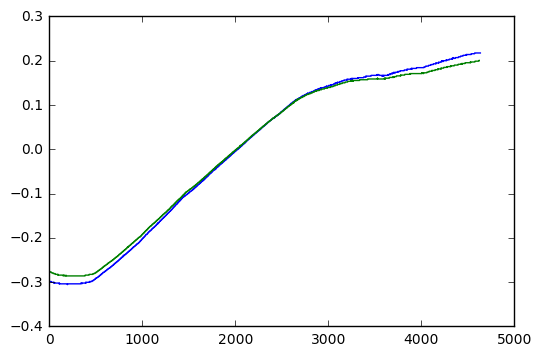

In [8]:
check_match_curves(4)

In [9]:
rmss = [compute_match_curves(x) for x in range(0,100)]

In [10]:
sorted(rmss)

[(0.0016889005522572362,
  84,
  'MS-DAR-00069-000-00366.jpg',
  'MS-DAR-00205-00009-000-00745.jpg'),
 (0.002863253005170983,
  94,
  'MS-DAR-00209-00014-000-00040.jpg',
  'MS-DAR-00209-00001-000-00053.jpg'),
 (0.004466517181644247,
  3,
  'MS-DAR-00085-000-00150.jpg',
  'MS-DAR-00084-00002-000-00307.jpg'),
 (0.0056417653823220065,
  7,
  'MS-DAR-00055-000-00261.jpg',
  'MS-DAR-00056-000-00103.jpg'),
 (0.0066477460818954,
  69,
  'MS-DAR-00062-000-00150.jpg',
  'MS-DAR-00046-00002-000-00292.jpg'),
 (0.00667011025054957,
  67,
  'MS-DAR-00209-00014-000-00082.jpg',
  'MS-DAR-00067-000-00020.jpg'),
 (0.007774177767876896,
  14,
  'MS-DAR-00209-00010-000-00084.jpg',
  'MS-DAR-00209-00014-000-00016.jpg'),
 (0.008153892315167038,
  24,
  'MS-DAR-00208-000-00048.jpg',
  'MS-DAR-00052-000-00252.jpg'),
 (0.009677079525184692,
  2,
  'MS-DAR-00087-000-00010.jpg',
  'MS-DAR-00087-000-00008.jpg'),
 (0.010071798016686293,
  85,
  'MS-DAR-00205-00002-000-00235.jpg',
  'MS-DAR-00205-00010-000-00191.j